# Comparing Fourier VS Wavelets VS Cosine Transform

In [81]:
import numpy as np
from matplotlib.image import imread
import pywt
import matplotlib.pyplot as plt
import cv2
import itertools


## Load and preprocess image

In [87]:
base_image = imread('../../data/other/Lenna_512x512.png')
grey_scaled_image = np.mean(base_image, -1)

## Define Untility function

The Peak Signal-to-Noise Ratio (PSNR) is a widely used metric for measuring the quality of reconstructed images compared to their original versions, especially in the context of image compression. PSNR is expressed in decibels (dB).

- **Higher PSNR value**: A higher PSNR indicates that the compression has preserved more of the original image's details, leading to a higher quality reconstructed image. In general, a higher PSNR is seen as better, indicating less distortion.

- **Lower PSNR value**: A lower PSNR suggests more distortion and a greater difference between the original and compressed images, implying lower quality of the reconstructed image.

PSNR is calculated using the following formula:

$$ \text{PSNR} = 10 \cdot \log_{10} \left( \frac{\text{MAX}_I^2}{\text{MSE}} \right) $$

where:
- $ \text{MAX}_I $ is the maximum possible pixel value of the image. For example, for an 8-bit grayscale image, the maximum value is 255.
- $ \text{MSE} $  is the mean squared error between the original and compressed image.

While PSNR provides a mathematical measure of image reconstruction quality, it doesn't always perfectly match human perception of visual quality. In other words, an image with a higher PSNR might not always look better to human observers compared to one with a lower PSNR. This is due to the PSNR metric's simplicity and its focus on pixel-level differences rather than taking into account how humans perceive visual information.

Here's a rough guide to PSNR values:
- **Below 30 dB**: The quality might be generally unacceptable, showing significant differences between the original and compressed images.
- **Between 30 dB to 40 dB**: This range is often considered as fair to good, with some noticeable differences between the original and compressed images.
- **Above 40 dB**: Images are generally perceived as being close to the original, with very minor differences. Quality is considered very good to excellent.

In [66]:
def PSNR(original_image:np.array, compressed_image:np.array):
    mse = np.mean((original_image - compressed_image) ** 2)
    if mse == 0:  # This means no difference between original and compressed images.
        return float('inf')  
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr

In [95]:
def compress_image(original_image: np.array, wavelet, level, keep):
    coeffs = pywt.wavedec2(data=original_image, wavelet=wavelet, level=level + 1)  # Adjusting level for 1-based indexing
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    Csoft = np.sort(np.abs(coeff_arr.reshape(-1)))

    thresh = Csoft[int(np.floor((1 - keep) * len(Csoft)))]
    
    ind = np.abs(coeff_arr) > thresh

    Cfilt = coeff_arr * ind
    coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')

    reconstructed_image = pywt.waverec2(coeffs_filt, wavelet=wavelet)
    # this was added just in case we need to plot it
    # I am not joking, I wasn't just bored
    # reconstructed_image_uint8 = np.clip(reconstructed_image, 0, 1) * 255  # Adjusting the range to [0,255] and clipping
    # reconstructed_image_uint8 = reconstructed_image_uint8.astype('uint8')
    return reconstructed_image

## Making experiments with compressing images with wavelet transform

### Defining hyperparams

In [100]:
maximum_level = 5
psnr = []
wavelets = ["haar", "db1", "db2", "bior1.1", "sym2"]
keep = 0.7  # we will keep 70% of data

### Plotting setting

In [102]:
fig, axs = plt.subplots(len(wavelets), maximum_level, figsize=(20, 20))
psnr_values = {wavelet: [] for wavelet in wavelets}
plt.ioff()
# remove ticks from plot
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=1)
    ax.tick_params(axis='both', which='minor', labelsize=1)  

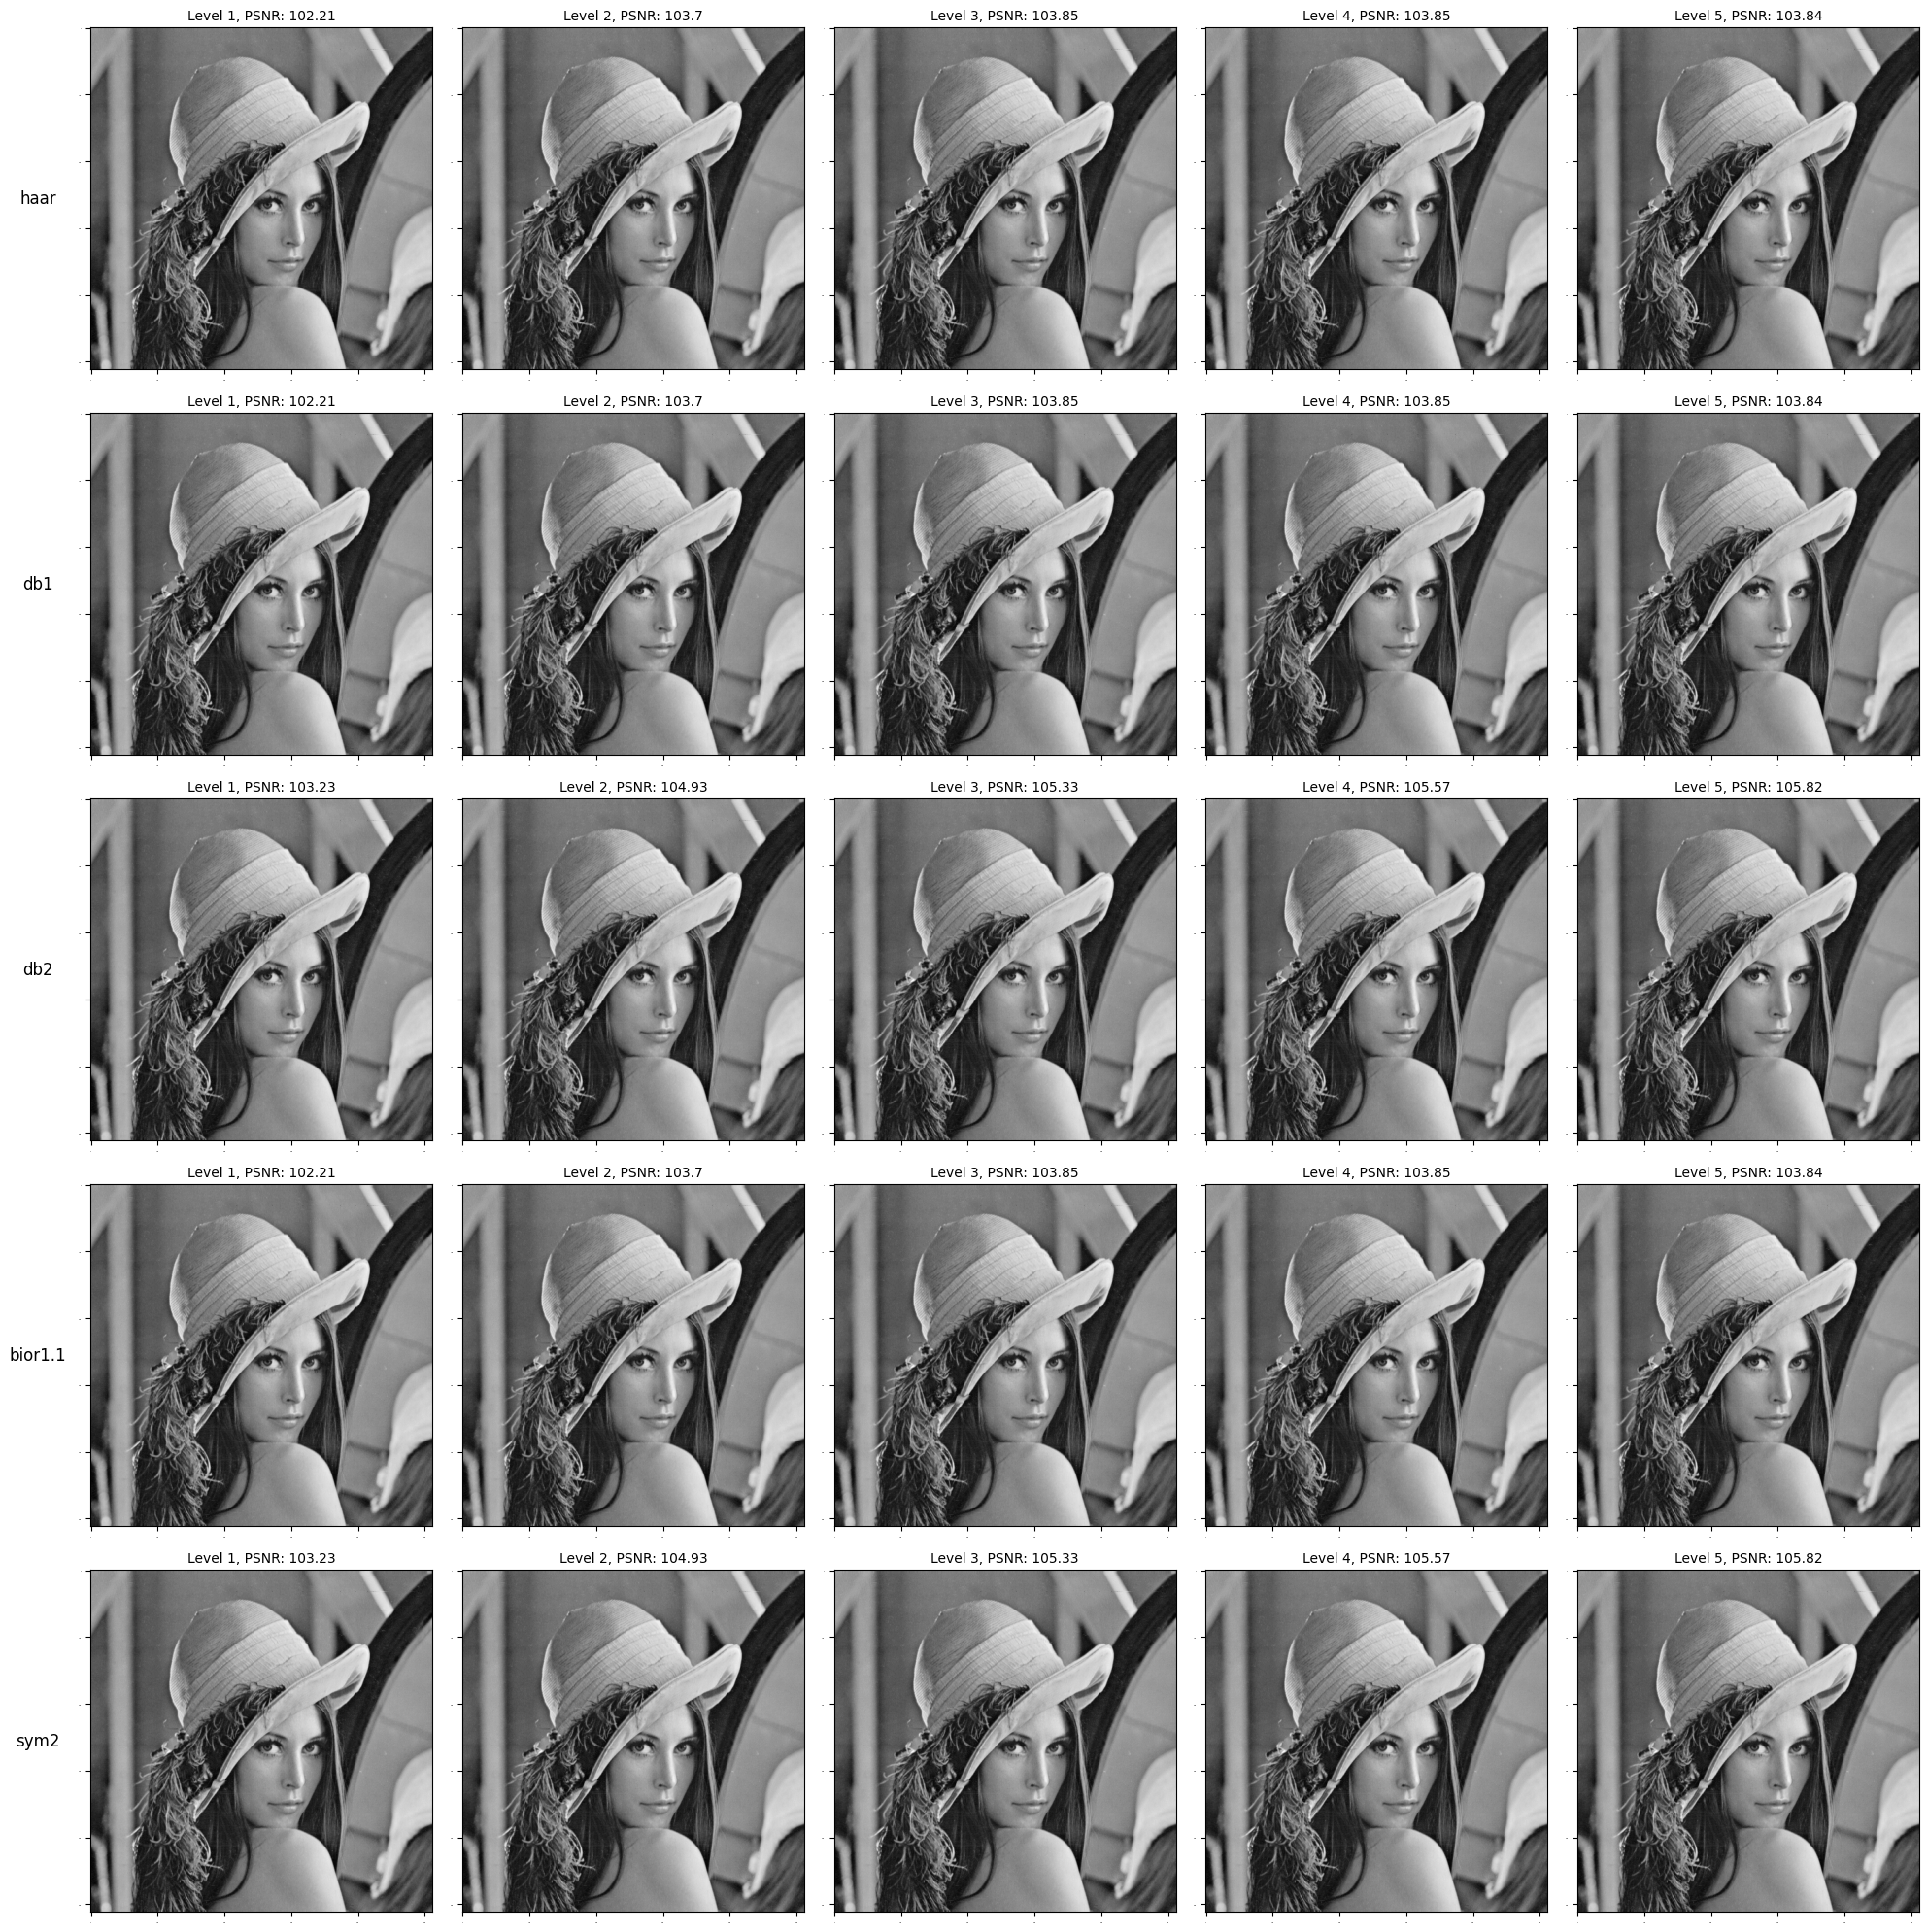

In [103]:
for level in range(maximum_level):
    for wave_index, wave in enumerate(wavelets):
        reconstructed_image = compress_image(grey_scaled_image, wavelet=wave, level=level, keep=keep)
        psnr_val = PSNR(grey_scaled_image, reconstructed_image)
        psnr_values[wave].append(psnr_val)

        axs[wave_index, level].imshow(reconstructed_image, cmap='gray')
        axs[wave_index, level].set_title(f'Level {level + 1}, PSNR: {np.round(PSNR(grey_scaled_image, reconstructed_image), 2)}', fontsize=10)

        if level == 0:  
            axs[wave_index, level].set_ylabel(wave, rotation=0, size='large', labelpad=30, verticalalignment='center')

plt.tight_layout()
plt.show()

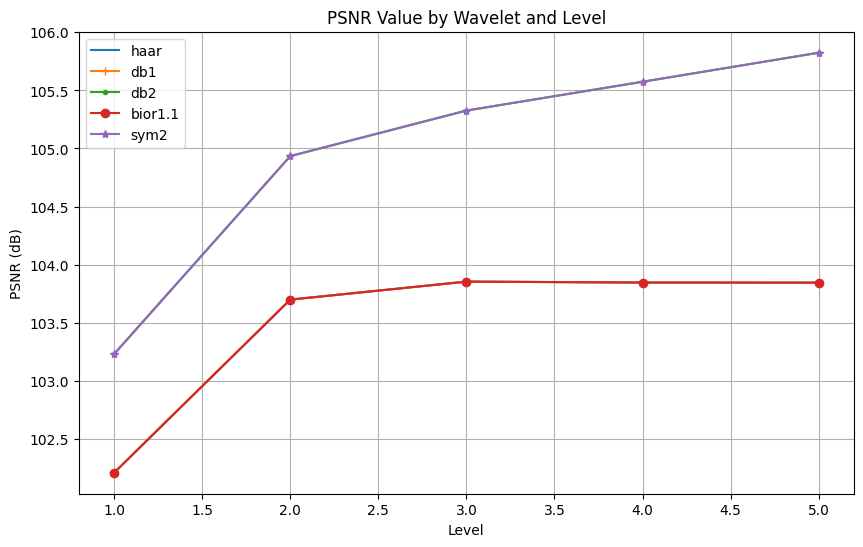

In [104]:
plt.figure(figsize=(10, 6))
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

for wavelet in wavelets:
    plt.plot(range(1, maximum_level + 1), psnr_values[wavelet], label=wavelet, marker=next(marker))

plt.xlabel('Level')
plt.ylabel('PSNR (dB)')
plt.title('PSNR Value by Wavelet and Level')
plt.legend()
plt.grid(True)
plt.show()

TO DO 
- DCT
- Fourier 